# Modeling human movement

## Restricted spatial features

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from pointing_model import PointingModel, features, utils, learning, plotting
import matplotlib.pyplot as plt
import pandas as pd

The ```PointingModel``` class provides utilities for loading, analysing and modeling the data. 

In [3]:
pointing = PointingModel({
    # configure load parameters
    'load_default_fast': True,
    'load': {
        'loading_path': './data_export',
        # 'loading_path': './data',
    }
})

Here we define some default values for the ongoing analyis. The ```feats``` variable contains a list of the desired features.

In [4]:
target_fields = utils.target_fields()
body_fields = utils.all_body_fields()
feats = utils.restricted_spatial_features()

## Feature analysis

Plotting the correlation matrix of the base body values with the target labels. Here we can see correlations between a markerset position and a target position, which gives clues about how to engineer features.

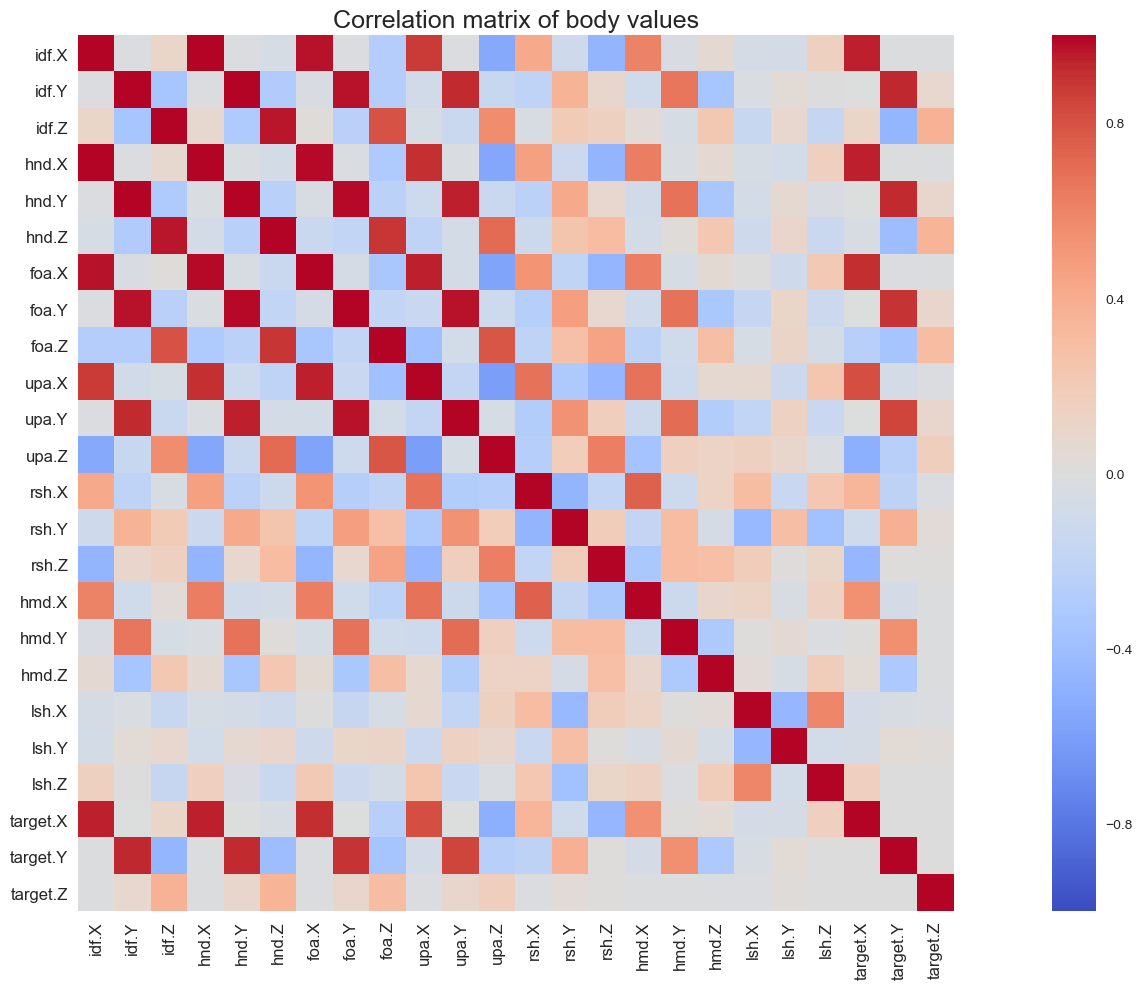

In [5]:
pointing.plot_correlation_matrix(base_fields=body_fields, force=True, additional_fields=target_fields)

Plotting the correlation matrix between the selected features and the target labels.

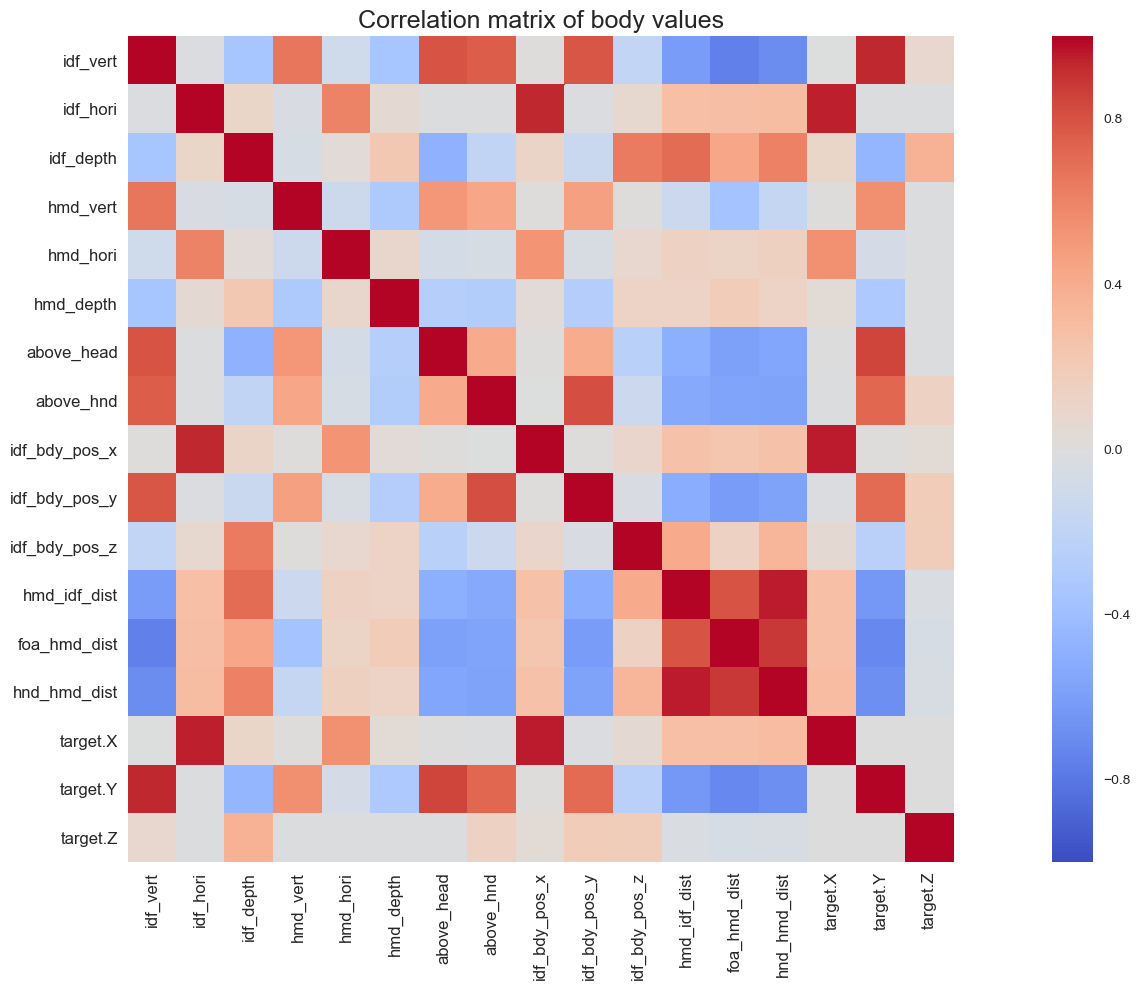

In [6]:
pointing.plot_correlation_matrix(base_fields=feats, force=True, additional_fields=target_fields)

Plotting the $\chi^2$-test between the selected features and the target labels.

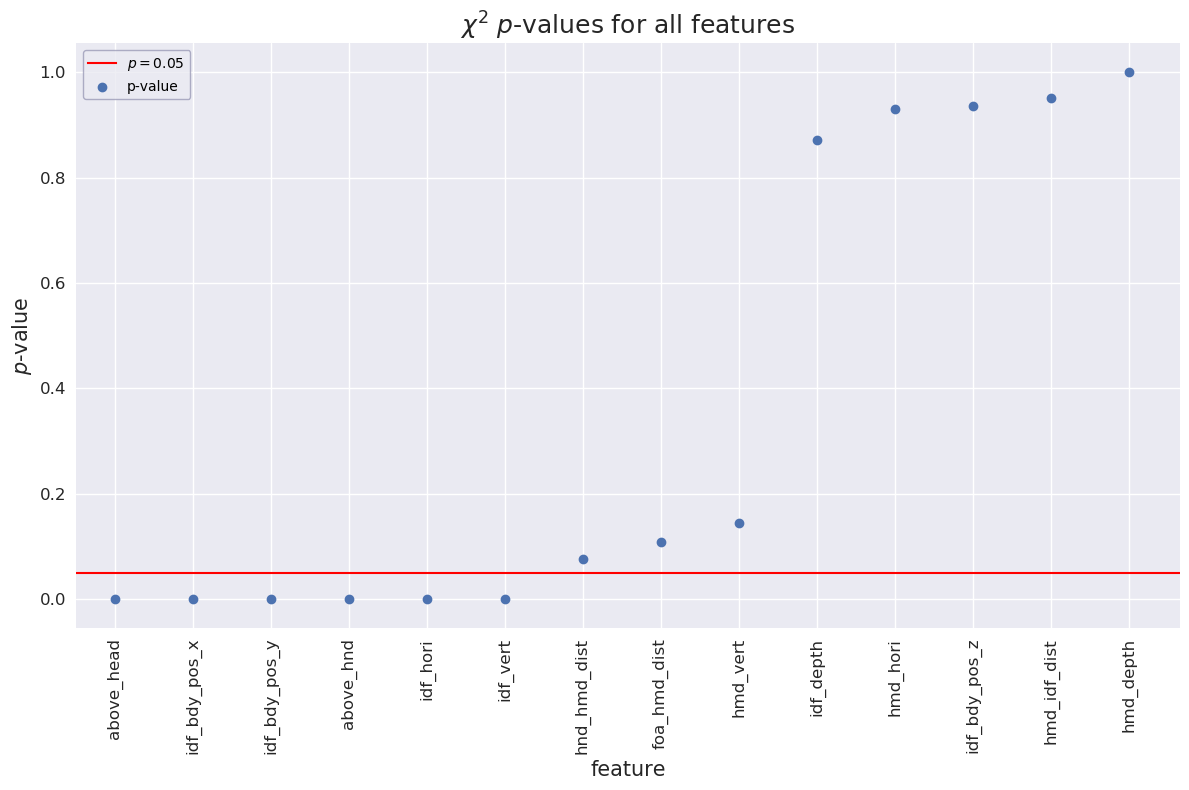

<Figure size 432x288 with 0 Axes>

In [7]:
pointing.plot_selectKBest_chi2(fields=feats, force=True)

Plotting the mutual information between the selected features and the target labels.

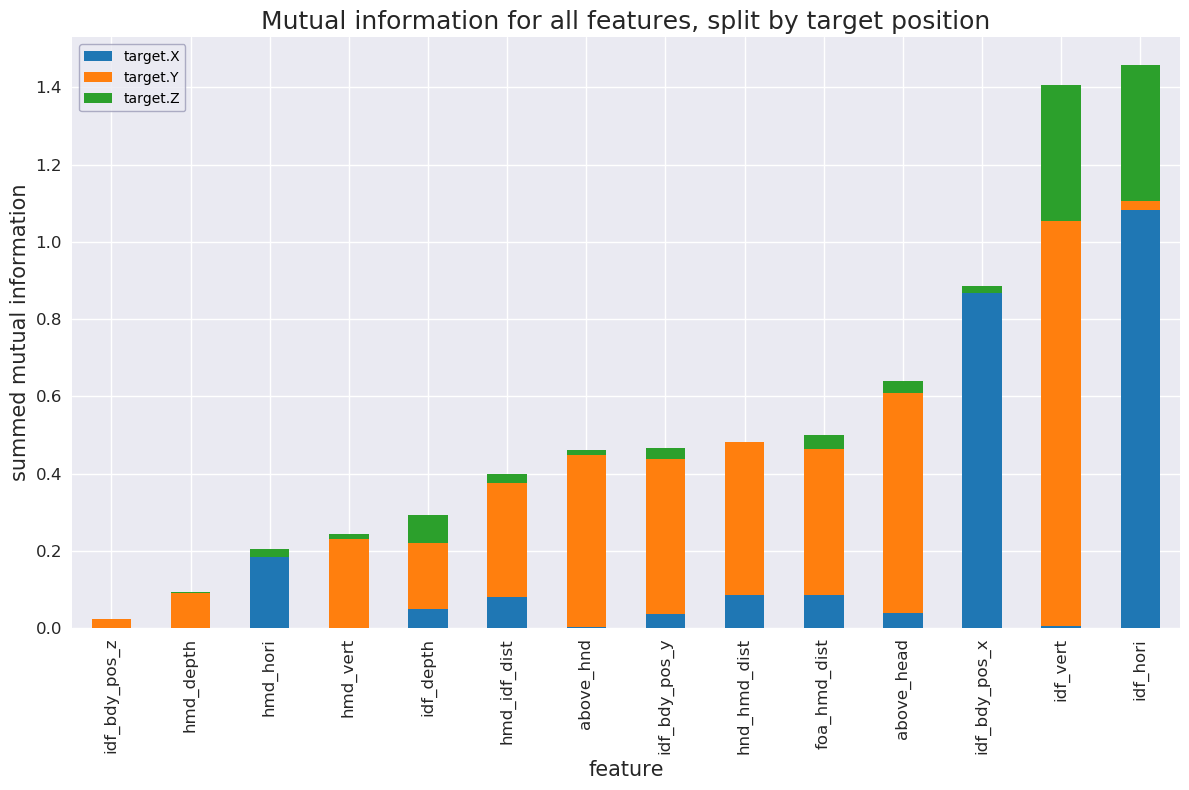

<Figure size 432x288 with 0 Axes>

In [8]:
pointing.plot_selectKBest_mutual_information(fields=feats, force=True)

Plotting feature importance, using ```sklearn.ensemple.ExtraTreesClassifier``` for computing the importance measure.

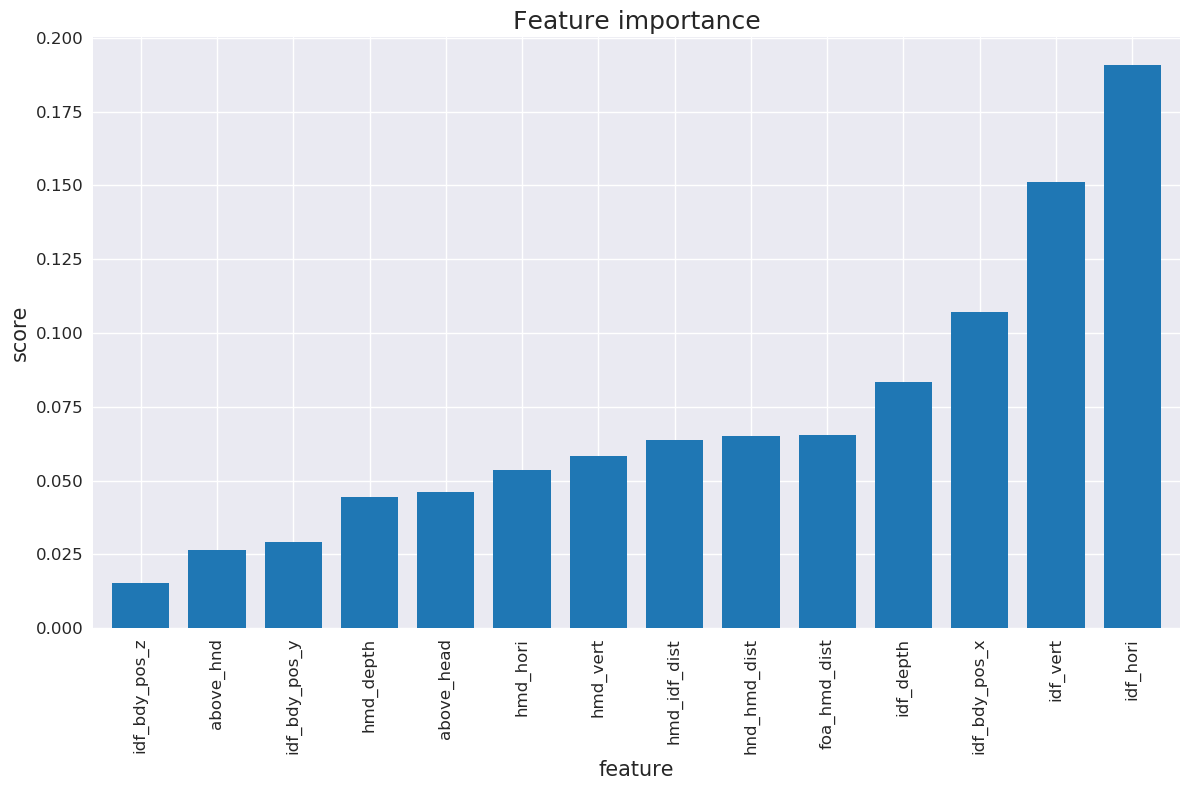

<Figure size 432x288 with 0 Axes>

In [9]:
pointing.plot_extratrees(fields=feats, force=True)

## Machine learning

### Pipeline
We first conduct a gridsearch, in order to find the best parameters for a model. Then these best parameters are used to train a model on 80% of the dataset. 20% of the data is then used to compute the test score, which we can compare against a 5-fold cross validation score obtained on first mentioned 80% of data.

### Classification

We use three different classification algorithms for comparison: Naive Bayes, SVM and random forest.

In [10]:
c_models = pointing.classification_models
c_models

[pointing_model.learning.models.svm.SupportVectorMachine,
 pointing_model.learning.models.random_forest.RandomForest,
 pointing_model.learning.models.naive_bayes.NaiveBayes]

We first conduct a gridsearch on the models to find the best performing parameters.

In [11]:
c_search = {}
for cm in c_models:
    m, p = pointing.machine_learning_gridsearch(cm, features=feats)
    c_search[m.name] = (cm, p)


****

Using:SVM
# Tuning hyper-parameters for precision
Best parameters set found on development set:
{'C': 40000, 'gamma': 0.001, 'kernel': 'rbf'}

Detailed classification report:
The model is trained on the full development set.
The scores are computed on the full evaluation set.
-----------------------
Report:
                   precision    recall  f1-score   support

(-1.0, 0.49, 1.5)       0.91      0.91      0.91        11
(-1.0, 0.49, 2.5)       0.88      0.88      0.88        17
(-1.0, 0.49, 3.5)       0.92      0.92      0.92        13
(-1.0, 1.49, 1.5)       1.00      1.00      1.00        11
(-1.0, 1.49, 2.5)       0.73      1.00      0.84         8
(-1.0, 1.49, 3.5)       1.00      0.77      0.87        13
(-1.0, 2.49, 1.5)       1.00      1.00      1.00        12
(-1.0, 2.49, 2.5)       0.89      1.00      0.94        17
(-1.0, 2.49, 3.5)       1.00      0.88      0.94        17
 (0.0, 0.49, 1.5)       1.00      1.00      1.00        13
 (0.0, 0.49, 2.5)       1.00      

The best parameters are stored in a dictionary for later use in training the models.

In [12]:
c_search

{'SVM': (pointing_model.learning.models.svm.SupportVectorMachine,
  {'C': 40000, 'gamma': 0.001, 'kernel': 'rbf'}),
 'Random Forest': (pointing_model.learning.models.random_forest.RandomForest,
  {'criterion': 'entropy',
   'max_depth': 16,
   'max_features': 'auto',
   'n_estimators': 175,
   'random_state': 0}),
 'Naive Bayes': (pointing_model.learning.models.naive_bayes.NaiveBayes,
  {'var_smoothing': 1e-09})}

We conduct both 5-fold cross validation and testing on the dataset. The validation and training is performed on 80% of the data, while the test set consists of 20% of the data.
Below a detailed classification report for each of the models can be found.

In [ ]:
c_scores = {}
for k in c_search:
    cm, p = c_search[k]
    m, s = pointing.machine_learning_kfold(cm, model_kwargs=p, cleanup=True, save=False, features=feats)
    c_scores[m.name] = s

At the end we compare the different scores and find the best performing model.

In [13]:
pd.DataFrame.from_dict(c_scores).T

,cross-validation,accuracy,f1-score
SVM,0.755699,0.769231,0.760857
Random Forest,0.737163,0.726496,0.723214
Naive Bayes,0.459377,0.404558,0.336385


### Regression

Also for regression we compare three different models: Linear Regression, SVM and random forest.

In [14]:
 r_models = pointing.regression_models
 r_models

[pointing_model.learning.models.svm.SupportVectorMachineRegression,
 pointing_model.learning.models.random_forest.RandomForestRegression,
 pointing_model.learning.models.linear_regression.LinearRegression]

We first conduct a gridsearch on the models to find the best performing parameters.

In [15]:
r_search = {'Linear Regression': (learning.LinearRegression, {})}
for rm in r_models:
    m, p = pointing.machine_learning_gridsearch(rm, features=feats)
    r_search[m.name] = (rm, p)


****

Using:SVM
# Tuning hyper-parameters
Best parameters set found on development set:
{'estimator__C': 10.0, 'estimator__gamma': 0.01, 'estimator__kernel': 'rbf'}

Detailed classification report:
The model is trained on the full development set.
The scores are computed on the full evaluation set.
-----------------------
distances:
                               pred              dist
                                  x     y     z      
(true, x) (true, y) (true, z)                        
-1.0      0.49      1.5       -1.02  0.53  1.67  0.39
                    2.5       -1.00  0.57  2.54  0.39
                    3.5       -0.83  0.69  2.99  0.67
          1.49      1.5       -1.11  1.44  1.95  0.49
                    2.5       -0.97  1.47  2.53  0.28
                    3.5       -0.81  1.49  2.81  0.75
          2.49      1.5       -0.94  2.46  1.61  0.30
                    2.5       -0.95  2.47  2.56  0.19
                    3.5       -0.83  2.38  3.06  0.52
 0.0      0.49  

AttributeError: 'MultiOutputRegressor' object has no attribute 'best_params_'

The best parameters are stored in a dictionary for later use in training the models.

In [16]:
r_search

{'SVM': (pointing_model.learning.models.svm.SupportVectorMachineRegression,
  {'estimator__C': 10.0,
   'estimator__gamma': 0.01,
   'estimator__kernel': 'rbf'}),
 'Random Forest Regression': (pointing_model.learning.models.random_forest.RandomForestRegression,
  {'criterion': 'mse',
   'max_depth': 11,
   'max_features': 'sqrt',
   'n_estimators': 100,
   'random_state': 0}),
 'Linear Regression': (pointing_model.learning.models.linear_regression.LinearRegression,
  {})}

We conduct both 5-fold cross validation and testing on the dataset. The validation and training is performed on 80% of the data, while the test set consists of 20% of the data.
Below a detailed classification report for each of the models can be found.


****

Using:SVM
5-fold cross validation score: 0.30339075606765004

Description of distances:
count    27.000000
mean      0.289167
std       0.328256
min       0.028901
25%       0.103708
50%       0.215593
75%       0.366467
max       1.704298
Name: (dist, real_mean), dtype: float64



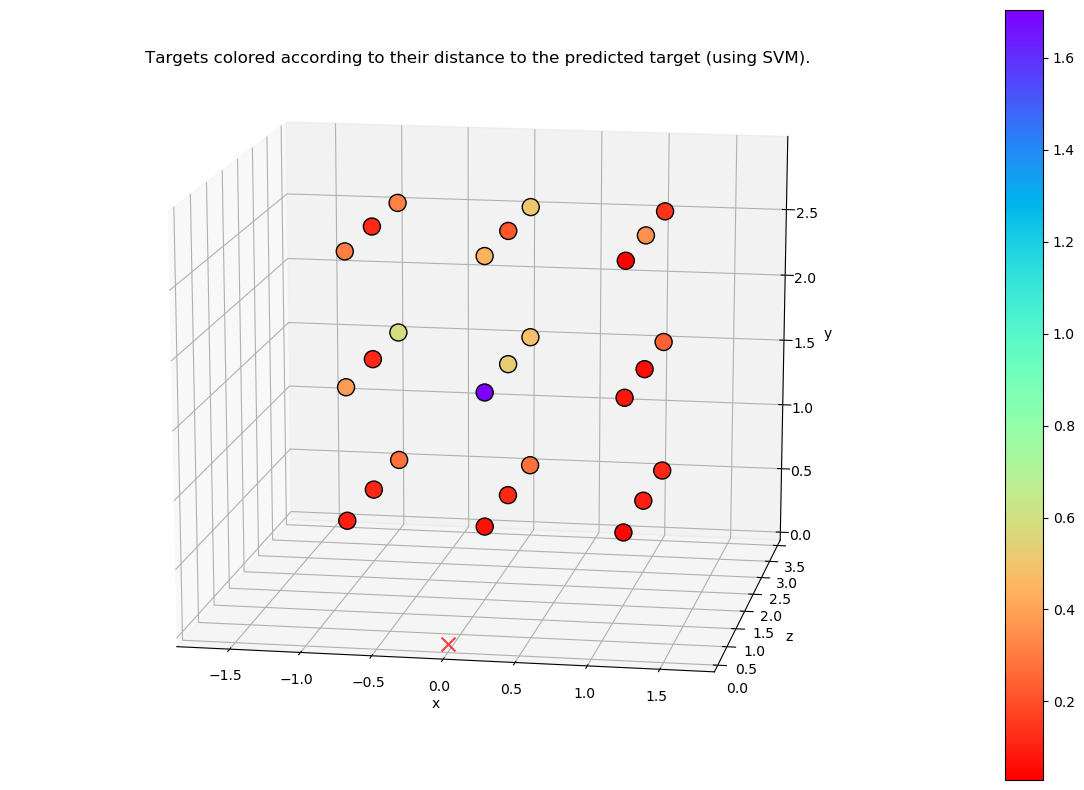

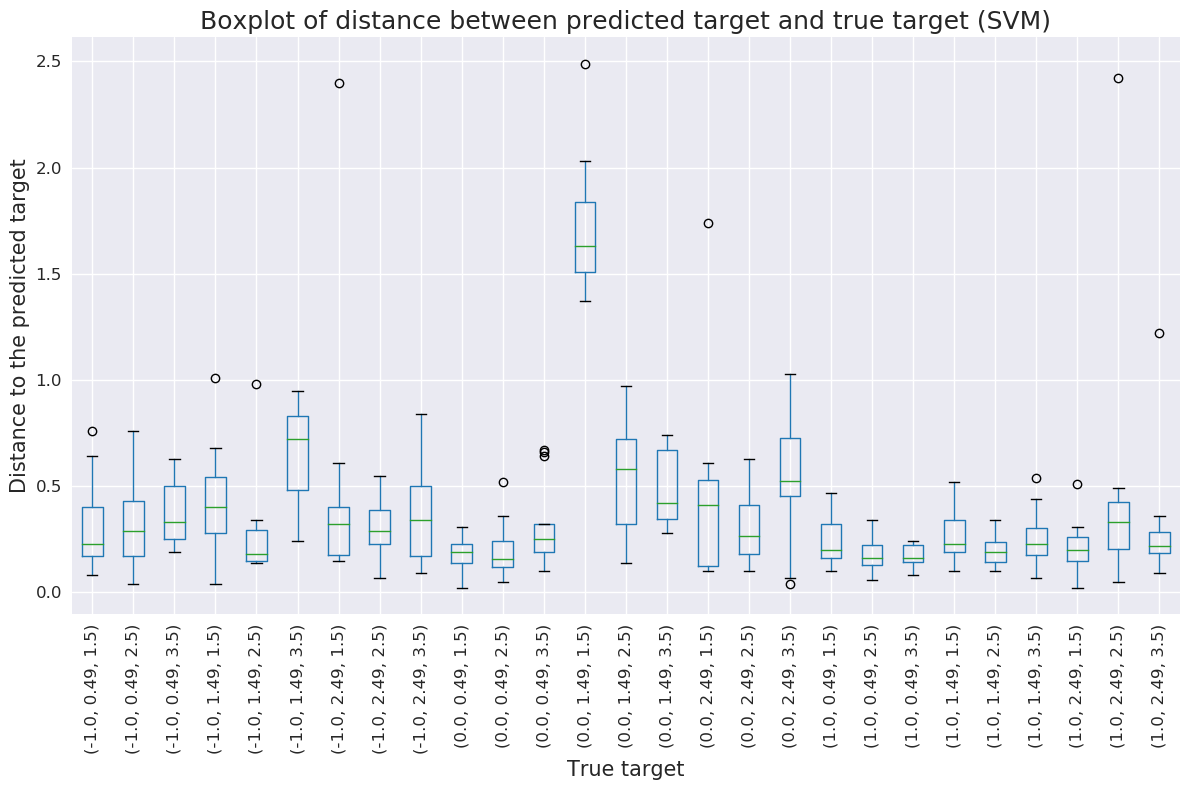

-----------------------
distances:
                               pred              dist
                                  x     y     z      
(true, x) (true, y) (true, z)                        
-1.0      0.49      1.5       -1.02  0.56  1.57  0.31
                    2.5       -1.01  0.50  2.61  0.31
                    3.5       -0.88  0.57  3.27  0.37
          1.49      1.5       -1.10  1.47  1.87  0.43
                    2.5       -1.04  1.49  2.61  0.30
                    3.5       -0.87  1.44  2.93  0.66
          2.49      1.5       -0.86  2.42  1.77  0.48
                    2.5       -0.97  2.48  2.61  0.29
                    3.5       -0.96  2.43  3.19  0.39
 0.0      0.49      1.5       -0.04  0.45  1.54  0.18
                    2.5        0.02  0.49  2.61  0.20
                    3.5       -0.05  0.58  3.25  0.32
          1.49      1.5       -0.02  1.34  3.20  1.72
                    2.5       -0.10  1.47  3.02  0.55
                    3.5       -0.04  1.57  3.02

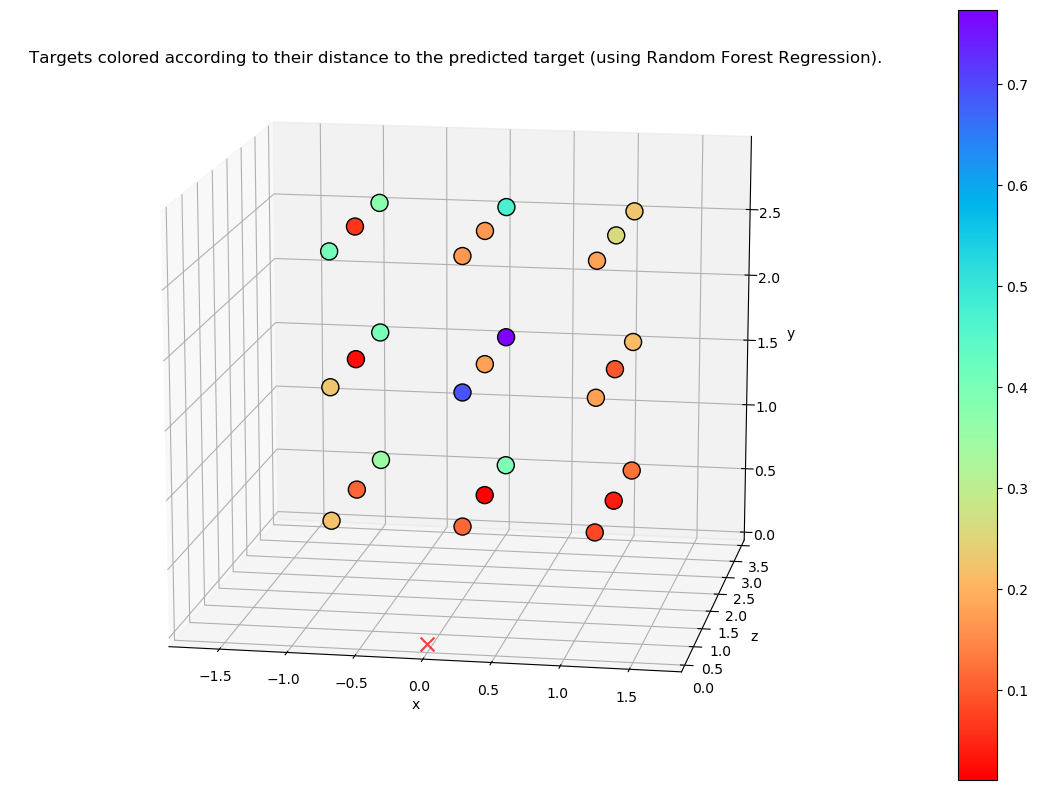

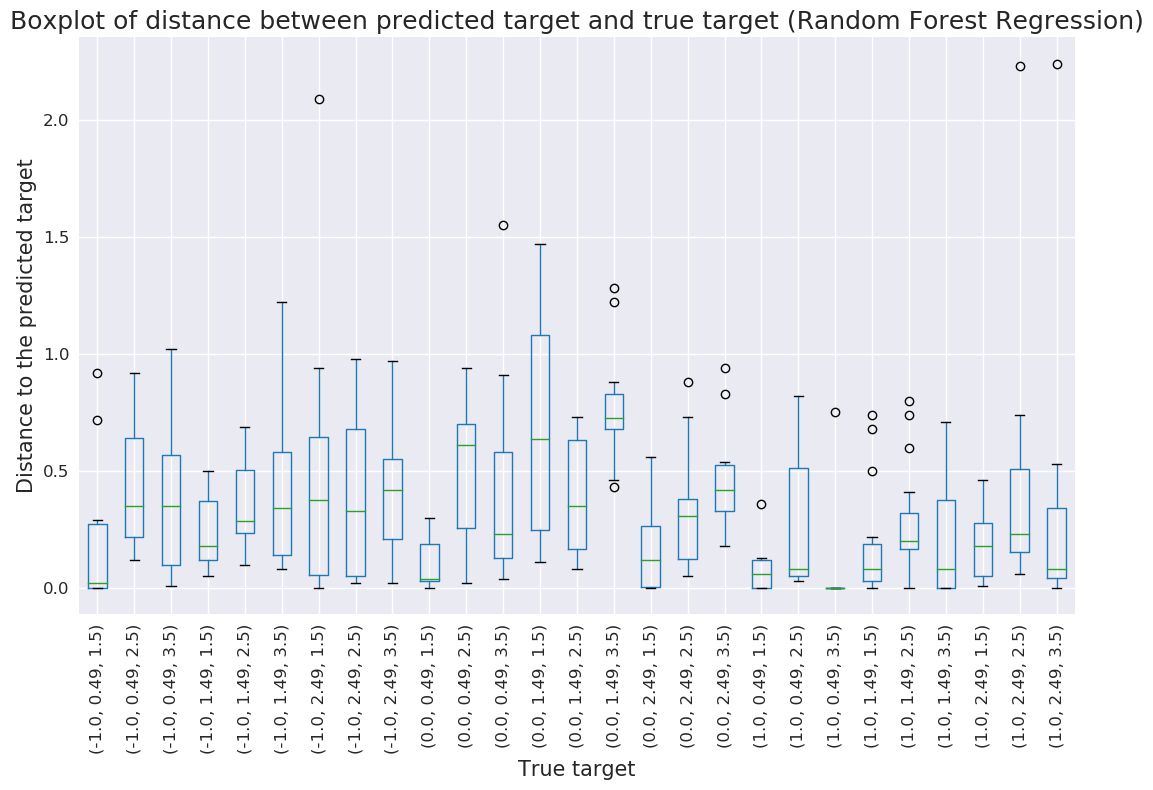

-----------------------
distances:
                               pred              dist
                                  x     y     z      
(true, x) (true, y) (true, z)                        
-1.0      0.49      1.5       -1.00  0.49  1.72  0.22
                    2.5       -1.00  0.50  2.61  0.42
                    3.5       -1.00  0.56  3.16  0.39
          1.49      1.5       -1.00  1.48  1.73  0.23
                    2.5       -1.00  1.49  2.52  0.34
                    3.5       -1.00  1.41  3.11  0.43
          2.49      1.5       -1.00  2.32  1.87  0.50
                    2.5       -1.00  2.49  2.44  0.39
                    3.5       -1.00  2.47  3.12  0.39
 0.0      0.49      1.5        0.00  0.49  1.61  0.11
                    2.5        0.00  0.50  2.49  0.48
                    3.5        0.00  0.57  3.11  0.41
          1.49      1.5        0.03  1.44  2.19  0.70
                    2.5        0.00  1.49  2.68  0.39
                    3.5        0.00  1.49  2.73

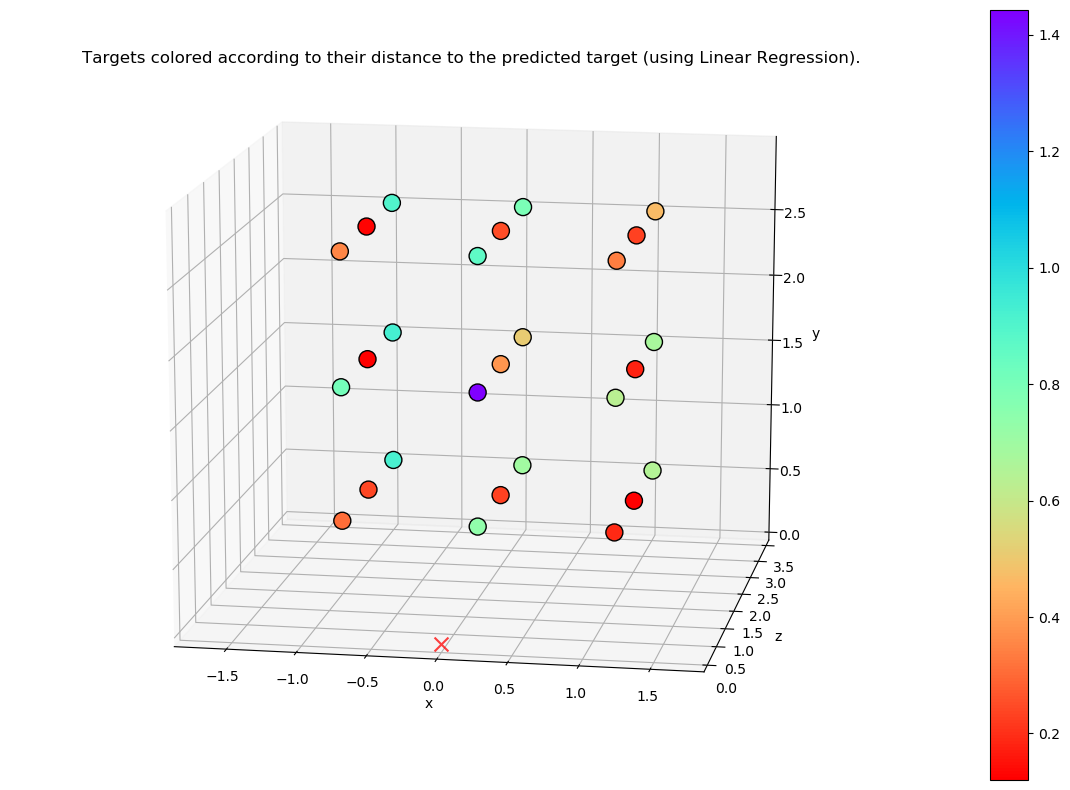

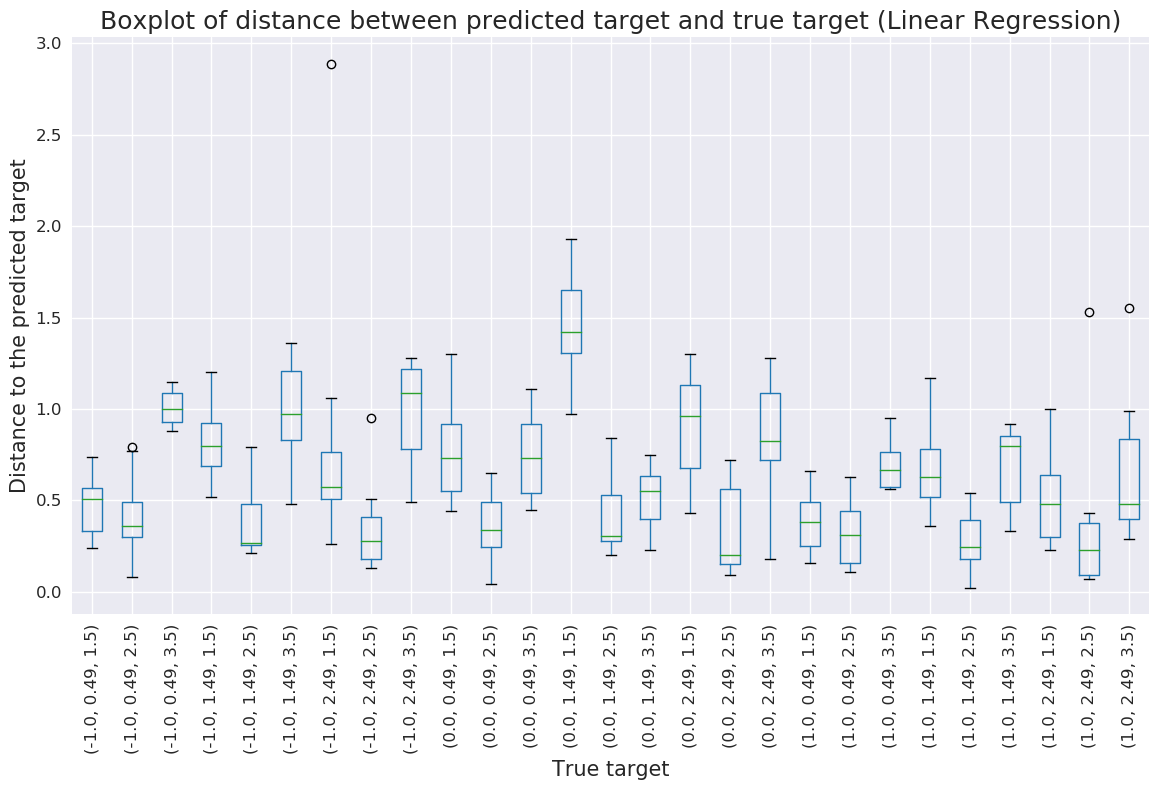

-----------------------
distances:
                               pred              dist
                                  x     y     z      
(true, x) (true, y) (true, z)                        
-1.0      0.49      1.5       -1.11  0.44  1.79  0.47
                    2.5       -0.96  0.69  2.38  0.41
                    3.5       -0.79  0.89  2.70  1.00
          1.49      1.5       -1.12  1.41  2.29  0.82
                    2.5       -0.92  1.40  2.50  0.38
                    3.5       -0.76  1.38  2.61  0.99
          2.49      1.5       -0.96  2.38  1.83  0.80
                    2.5       -0.90  2.46  2.43  0.33
                    3.5       -0.72  2.32  2.66  0.99
 0.0      0.49      1.5       -0.04  0.21  2.18  0.78
                    2.5       -0.03  0.59  2.71  0.35
                    3.5       -0.10  0.78  2.87  0.75
          1.49      1.5       -0.00  1.32  2.93  1.46
                    2.5       -0.11  1.38  2.85  0.42
                    3.5       -0.04  1.37  3.01

In [17]:
r_scores = {}
for k in r_search:
    cm, p = r_search[k]
    p = {i.replace('estimator__', ''): p[i] for i in p}
    m, s = pointing.machine_learning_kfold(
        cm, model_kwargs=p, cleanup=True, features=feats,
        analyze_distances=plotting.analyze_distances, save=False
    )
    r_scores[m.name] = s

At the end we compare the different scores and find the best performing model.

In [18]:
pd.DataFrame.from_dict(r_scores).T

,cross-validation,mean_distance,rmse
SVM,0.303391,0.289167,0.308179
Random Forest Regression,0.263129,0.242987,0.286013
Linear Regression,0.422386,0.522309,0.419077
